In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os as os
import math


### Carga de datos

In [12]:

#TODO Introducir el dataset con el que se vaya a trabajar
station = 'jci'
input_path = f'{station}_clean.csv'


df = pd.read_csv(f'data_{station}/{input_path}', parse_dates=['date'])
cols = [col for col in df.columns]

df_original = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163318 entries, 0 to 163317
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   date    163318 non-null  datetime64[ns, UTC]
 1   temp    152432 non-null  float64            
 2   skt     158459 non-null  float64            
 3   dir     158187 non-null  float64            
 4   vel     158999 non-null  float64            
 5   hr      152241 non-null  float64            
 6   prec    56760 non-null   float64            
 7   pres    152917 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 10.0 MB


### Ventana móvil

In [13]:

window_size = 365 * 24  
nulls_tolerance = 14 * 24 # 2 semanas horario
value_counts = pd.DataFrame()

#Nos saltamos la columna de fecha e identificacion de la base
for col in df.columns:
    if df[col].dtype != np.float64 and df[col].dtype != np.int64:        
        print(f'{col} is not a number')
        continue
    print(f'{col} is a number')
    df[f'{col}_{station}'] = df[col].rolling(window=window_size, min_periods=1).apply(
        lambda x: 0 if x.isnull().sum() > nulls_tolerance or len(x) < window_size else 1
    )
    df[f'{col}_{station}'] = df[f'{col}_{station}'].replace({np.nan: 0})
    df[f'{col}_{station}'] = df[f'{col}_{station}'].astype(np.int8)

    value_counts[col] = df[f'{col}_{station}'].value_counts().reindex([0, 1], fill_value=0)



print(df.tail(20))



date is not a number
temp is a number
skt is a number
dir is a number
vel is a number
hr is a number
prec is a number
pres is a number
                            date  temp  skt    dir  vel    hr  prec   pres  \
163298 2024-03-23 04:00:00+00:00   0.7  0.9  196.0  2.6  86.0   0.0  982.3   
163299 2024-03-23 05:00:00+00:00   0.4  0.6  197.0  4.3  86.0   0.0  982.9   
163300 2024-03-23 06:00:00+00:00   0.3  0.5  203.0  5.6  82.0   0.0  983.6   
163301 2024-03-23 07:00:00+00:00   0.6  0.8  197.0  2.6  83.0   0.0  984.1   
163302 2024-03-23 08:00:00+00:00   0.7  0.9  217.0  1.6  88.0   0.0  984.1   
163303 2024-03-23 09:00:00+00:00   0.9  1.1  206.0  1.3  85.0   0.0  984.5   
163304 2024-03-23 10:00:00+00:00   1.1  1.2  217.0  3.7  81.0   0.0  984.9   
163305 2024-03-23 11:00:00+00:00   1.0  1.2  233.0  1.7  84.0   0.0  985.4   
163306 2024-03-23 12:00:00+00:00   0.8  1.1  163.0  2.2  88.0   0.0  985.7   
163307 2024-03-23 13:00:00+00:00   0.6  0.9  244.0  2.2  90.0   0.0  986.2   
163308 

In [14]:
# Exportación

df.to_csv(f'data_{station}/{station}_flagged.csv', index=False)

### Visualización de los datos

In [15]:
import math

num_cols = len(df.columns) - 1  # Restamos 1 para excluir la columna 'fhora'
num_rows = math.ceil(num_cols / 4)  # Redondea hacia arriba para obtener el número de filas necesarias

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))  # Ajusta el tamaño de la figura según el número de filas

# Aplanar el array de ejes para poder iterar sobre él
axes = axes.flatten()

# Iterar sobre las columnas (excluyendo 'fhora') y generar gráficos
for ax, col in zip(axes, df.columns.drop('date')):
    print(col)
    ax.plot(df['date'], df[col])
    ax.set_xlabel('date')
    ax.set_ylabel(col)
    ax.set_title(f'{col} a lo date de fhora')

# Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 4
if num_cols % 4:
    for ax in axes[num_cols:]:
        ax.remove()

plt.tight_layout()
plt.savefig(f'resource/flagged_period_{station}_14days_window.png')

plt.show()

### Generación de Heatmap

C:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Temp\ipykernel_12952\807550161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flags['date'] = df['date']
C:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Temp\ipykernel_12952\807550161.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_flags.index = df_flags.index.to_period('M')


6 2
temp_jci procede al mapa de calor
skt_jci procede al mapa de calor
dir_jci procede al mapa de calor
vel_jci procede al mapa de calor
hr_jci procede al mapa de calor
prec_jci procede al mapa de calor


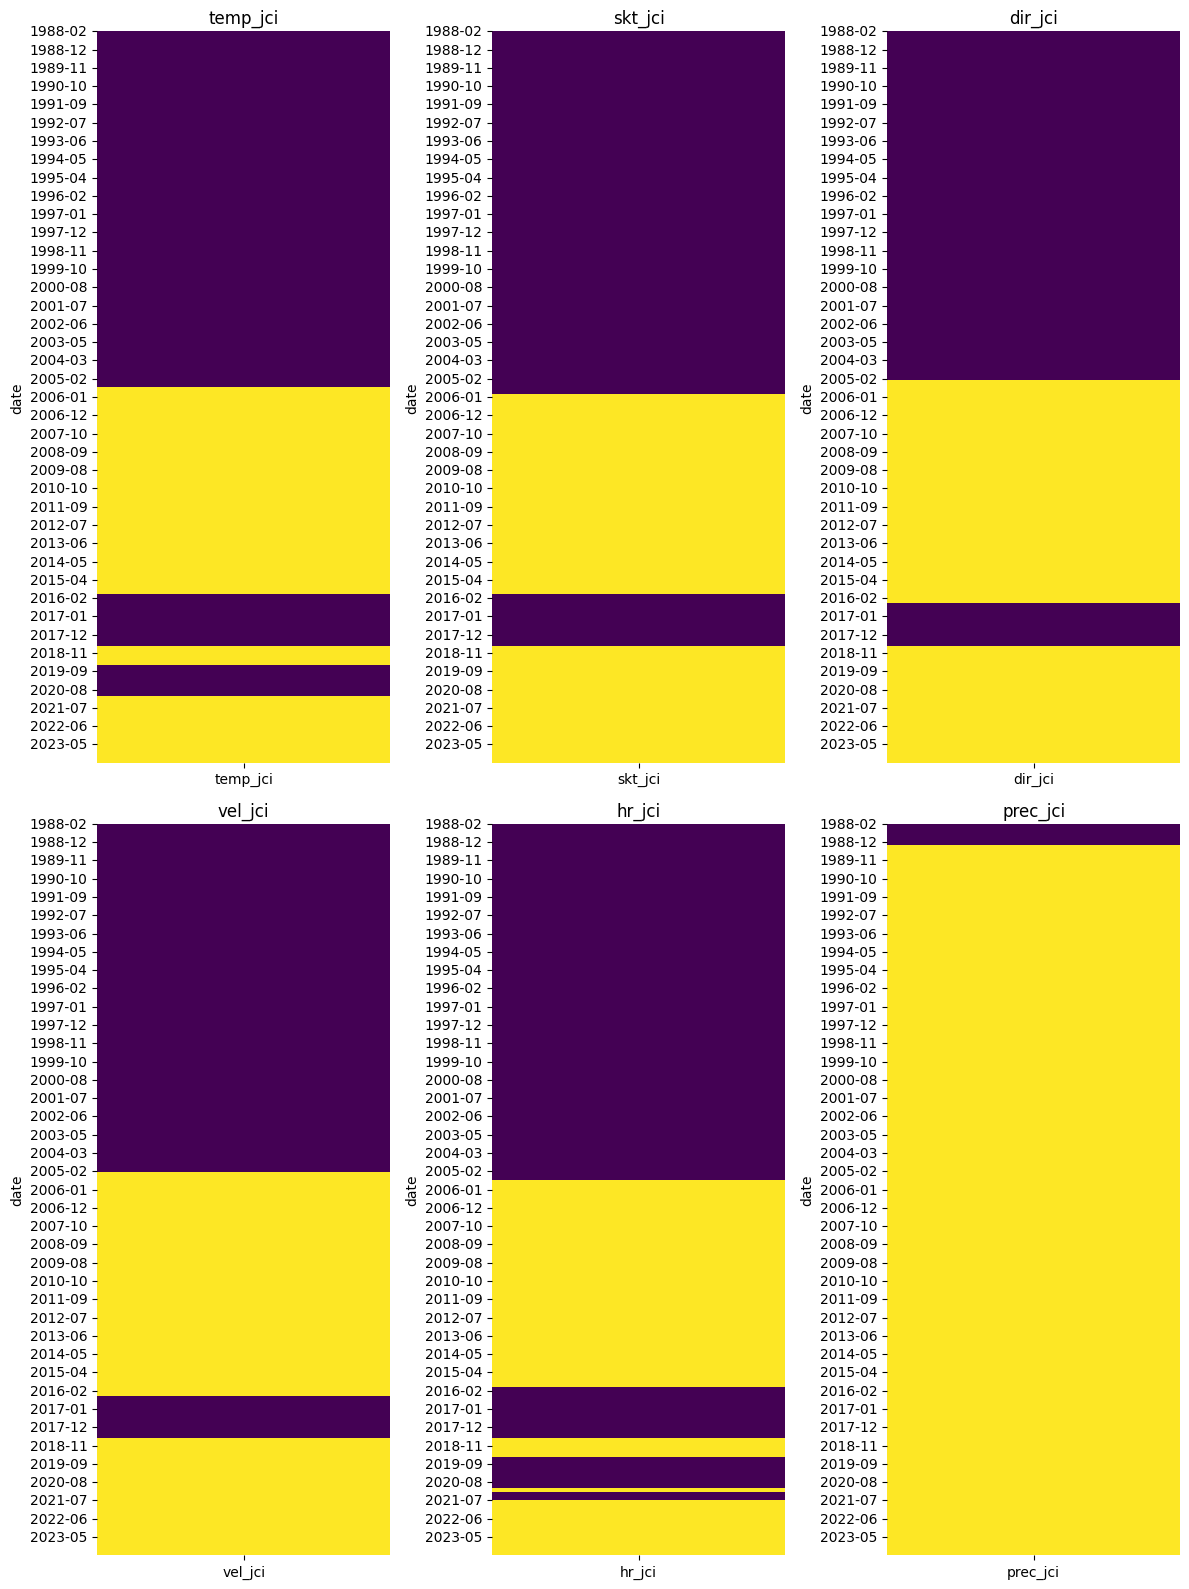

,date,temp,skt,dir,vel,hr,prec,pres,temp_jci,skt_jci,dir_jci,vel_jci,hr_jci,prec_jci,pres_jci
0,1988-02-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,0,0,0,0,0
1,1988-02-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,0,0,0,0,0
2,1988-02-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,0,0,0,0,0
3,1988-02-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,0,0,0,0,0
4,1988-02-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,0,0,0,0,0,0


In [11]:

df_flags = df[[col for col in df.columns if station in col]]
df_flags['date'] = df['date']

df_flags.set_index('date', inplace=True)
df_flags.index = pd.to_datetime(df_flags.index)
df_flags.index = df_flags.index.to_period('M') 

num_cols = len(df_flags.columns)-1

num_rows = math.ceil(num_cols / 3)  
print(num_cols, num_rows)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 8 * num_rows))  # Ajusta el tamaño de la figura según el número de filas

# Aplanar el array de ejes para poder iterar sobre él
axes = axes.flatten()

# Iterar sobre las columnas y generar gráficos
for ax, col in zip(axes, df_flags.columns):
    if col != 'date':
        print(f'{col} procede al mapa de calor')
        sns.heatmap(df_flags[[col]], cbar=False, cmap='viridis', ax=ax)
        ax.set_title(col)
    

# Eliminar los ejes sobrantes si el número de columnas no es múltiplo de 3
if num_cols % 3:
    for ax in axes[num_cols:]:
        ax.remove()

plt.tight_layout()
plt.savefig(f'resource/heatmap_figure_{station}_30days_window.png')
plt.show()

df.head()

In [41]:
df_seleccion_periodo = df[['gdc_ts', 'ts']].loc['2015-01-01':'2015-03-01']
df_seleccion_periodo.to_csv('periodo_seleccionado.csv')

### Código para examinar una sola columna de forma individual

In [5]:
df_2006 = pd.read_json(f'data_{station}/{station}_2006.json')
df_2006.head()

,identificacion,nombre,latitud,longitud,altitud,srs,alt_nieve,ddd,dddstd,dddx,...,global,ir_solar,neta,par,tcielo,ttierra,uvab,uvb,uvi,qdato
0,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,334,0,0,...,0,0,0,0,0,0,0,0,0,0
1,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,333,0,0,...,0,0,0,0,0,0,0,0,0,0
2,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,340,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,342,0,0,...,0,0,0,0,0,0,0,0,0,0
4,89070,GdC Estacion meteorologica,-62.97697,-60.67528,12,WGS84,0,343,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
target = 'lluv'

plt.figure(figsize=(10, 6))
plt.plot(df_2006['fhora'], df_2006[f'{target}'])
plt.xlabel('fhora')
plt.ylabel(f'{target}')
plt.title(f'{target} a lo largo de fhora')
plt.show()